## Domain adaptation (5 pts total)

In this seminar you will adapt a pre-trained machine translation model for the hotel review translation task you solved a few weeks ago. 

This time it comes with a few complications:
* Harder task: __en -> ru__ instead of __ru -> en__
* You are given a model pre-trained on WMT. Visit [statmt.org](http://statmt.org/) for more details.
* The baseline model already includes attention and some hacks

With luck and skills on your side, you will adapt it to improve hotel translation quality.

In [1]:
!pip3 install subword-nmt &> log
!wget https://github.com/yandexdataschool/nlp_course/raw/master/week09_da/data.tar.gz
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/week09_da/utils.py
!tar -xvzf data.tar.gz
!mv data/* .
!wget https://www.dropbox.com/s/xm73pjug7eq1rff/model-pretrained.npz?dl=1 -O model-pretrained.npz

--2018-12-03 00:19:58--  https://github.com/yandexdataschool/nlp_course/raw/master/week09_da/data.tar.gz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/week09_da/data.tar.gz [following]
--2018-12-03 00:19:59--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/week09_da/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3242995 (3.1M) [application/octet-stream]
Saving to: ‘data.tar.gz.1’

data.tar.gz.1       100%[===================>]   3.09M  14.5MB/s    in 0.2s    

2018-12-03 00:19:59 (14.5 MB/s) - ‘data.tar.gz.1’ saved [3242995/3242995]

--2018-12

### Data preprocessing

We provide you with a pre-trained model that uses Byte Pair Encodings [(bpe)](https://github.com/rsennrich/subword-nmt) to segment rare words into sub-word units. 

It is important that we fine-tune our model using the same set of BPE rules.

In [1]:
import numpy as np
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

bpe = {}
for lang in ['en', 'ru']:
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

In [2]:
print(bpe['ru'].process_line(tokenize("Скажи: какого цвета глаза у ветра?")))

ска@@ жи : какого цвета глаза у вет@@ ра ?


In [3]:
data_inp_raw = list(open('./train.domain.en'))
data_out_raw = list(open('./train.domain.ru'))

print(data_inp_raw[0])
print(data_out_raw[0])

cordelia hotel is situated in tbilisi , a 3 - minute walk away from saint trinity church .

отель cordelia расположен в тбилиси , в 3 минутах ходьбы от свято - троицкого собора .



In [4]:
# convert lines into space-separated tokenized bpe units

data_inp = [bpe['en'].process_line(tokenize(line)) for line in data_inp_raw]
data_out = [bpe['ru'].process_line(tokenize(line)) for line in data_out_raw]

In [5]:
assert data_inp[0] == 'cor@@ del@@ ia hotel is situated in t@@ bil@@ isi , a 3 - minute walk away from saint tr@@ inity church .'
assert data_out[500] == 'некоторые номера также располага@@ ют бал@@ ко@@ ном или тер@@ ра@@ со@@ й .'

In [6]:
from sklearn.model_selection import train_test_split
data_inp, data_out = map(np.array, [data_inp, data_out])
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)

### Model

For this assignment, you are given a pre-trained neural machine translation model:
* bidirectional LSTM encoder
* single LSTM decoder with additive attention

It was trained till convergence on the general dataset of news, websites and literature.


In [7]:
import numpy as np
import tensorflow as tf
import utils
tf.reset_default_graph()
sess = tf.InteractiveSession()

inp_voc = utils.Vocab(open('tokens.en').read().split('\n'))
out_voc = utils.Vocab(open('tokens.ru').read().split('\n'))

model = utils.Model('mod', inp_voc, out_voc)
utils.load(tf.trainable_variables(), 'model-pretrained.npz')

Using TensorFlow backend.


In [8]:
src = 'i am the monument to all your sins'
src = bpe['en'].process_line(tokenize(src))
trans, _ = model.translate_lines([src])
print(trans)

['я - памят@@ ник всем гре@@ ха@@ м']


### Estimate baseline quality

As before, we shall estimate our model's quality using [BLEU](https://en.wikipedia.org/wiki/BLEU) metric.

This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

One important thing about BLEU is that it is usually computed on a __corpora level__:
* first you count precisions over the entire test set
* then you do the geometric averaging and apply penalties

In [9]:
from nltk.translate.bleu_score import corpus_bleu
def bleu(references, translations):
    """ Estimates corpora-level BLEU score of predicted translations given references """
    return corpus_bleu([[ref.split()] for ref in references], 
                       [trans.split() for trans in translations]) * 100

In [10]:
bleu(['a cat sat on a mat', 'i love bees'], 
     ['a cat sat on a cat', 'i hate people'])

58.143073696821936

__Task 1 (1 point):__ evaluate baseline BLEU


In [11]:
def evaluate(model, inp_lines, out_lines):
    """
    Estimates model's corpora level bleu
    :param inp_lines: a list of BPE strings in source language
    :param out_lines: a list of BPE strings in target language
    :returns: model's BLEU (float scalar)
    
    Important:
    * Make sure to de-BPEize both translations and references. You can do that with str.replace
    * Use model.translate_lines with default max_len
    * If you're low on RAM, split data in several batches and translate sequentially
    """
    trans, _ = model.translate_lines(inp_lines)
    trans = [translation.replace('@@ ', '') for translation in trans]
    
    return bleu(out_lines, trans)

In [12]:
evaluate(model, dev_inp[:500], dev_out[:500])

8.155365386733743

### Naive training (1.5 points)

The simplest thing you can do in supervised domain adaptation is to simply fine-tune your model on the target domain data.

Here's a reminder of what training objective looks like:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__.



In [13]:
from utils import select_values_over_last_axis

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    """
    first_state = model.encode(inp, **flags)
    batch_size = tf.shape(inp)[0]
    bos = tf.fill([batch_size], model.out_voc.bos_ix)
    first_logits = tf.log(tf.one_hot(bos, len(model.out_voc)) + 1e-30)
    
    def step(blob, y_prev):
        h_prev = blob[:-1]
        h_new, logits = model.decode(h_prev, y_prev, **flags)
        return list(h_new) + [logits]

    *states_seq, logits_seq = tf.scan(step,
                                       initializer=list(first_state) + [first_logits],
                                       elems=tf.transpose(out))

    # gather state and logits, each of shape [time, batch, ...]
    logits_seq = tf.concat((first_logits[None], logits_seq),axis=0)
    #convert from [time, batch,...] to [batch, time, ...]
    logits_seq = tf.transpose(logits_seq, [1, 0, 2])
    
    logprobs_seq = tf.nn.log_softmax(logits_seq, dim=-1)
    
    logp_out = select_values_over_last_axis(logprobs_seq, out)
    mask = utils.infer_mask(out, out_voc.eos_ix)
    return -tf.reduce_sum(logp_out * mask) / tf.reduce_sum(mask)

### Training loop

In [14]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)

train_step = tf.train.AdamOptimizer().minimize(loss)
utils.initialize_uninitialized()

Instructions for updating:
dim is deprecated, use axis instead


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from tqdm import tqdm, trange

batch_size = 128
metrics = {'train_loss': [], 'dev_bleu': [] }

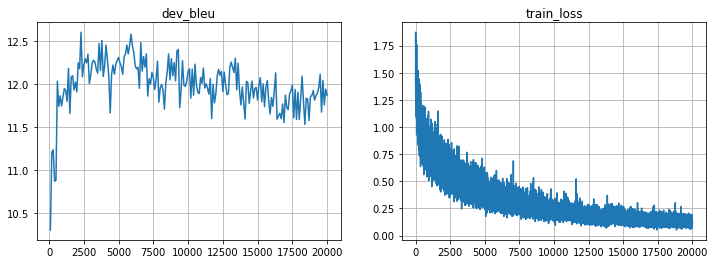

Mean loss=0.108


100%|██████████| 20000/20000 [4:07:57<00:00,  1.34it/s]


In [16]:
for _ in trange(20000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=32)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, evaluate(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [17]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 30, "We kind of need a higher bleu BLEU from you. Kind of right now."

AssertionError: We kind of need a higher bleu BLEU from you. Kind of right now.

In [ ]:
#print translations of some random dev lines
<YOUR CODE>

### Domain adaptation with KL penalty (2.5 pts)

The problem with fine-tuning is that model can stray too far from the original parameters and forget useful information. One way to mitigate this problem is to use KL penalty:

$$ Loss = (1 - \lambda) \cdot L_{xent} + \lambda \cdot {1 \over N} \underset {x, y_t} \sum KL(P_{teacher}(y_t|x, y_0, ..., y_{t-1}) || P_{student}(y_t|x, y_0, ..., y_{t-1}))$$

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = utils.Model('mod', inp_voc, out_voc)
utils.load(tf.trainable_variables(), 'model-pretrained.npz')

teacher = utils.Model('teacher', inp_voc, out_voc)

teacher_ckpt = np.load('model-pretrained.npz')
teacher_ckpt = { name.replace('mod/', 'teacher/'): teacher_ckpt[name] for name in teacher_ckpt}
np.savez('teacher.npz', **teacher_ckpt)
utils.load(tf.trainable_variables(), 'teacher.npz')

In [ ]:

def compute_loss_with_kl(model, teacher, inp, out, lambda_coeff=0.25, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :param lambda_coeff: lambda from the formula above.
    
    use lambda_coeff from outer scope
    """
    
    loss = <YOUR CODE>
    
    return loss

In [ ]:
### Do it yourself: create training step operations and 
# feel free to copy the code from simple fine-tuning
<YOUR CODE>

In [ ]:
<YOUR CODE: training loop>

In [ ]:
### Do it yourself: estimate the final quality
# feel free to reuse the code from simple fine-tuning
<YOUR CODE>

### Bonus tasks:
Both tasks start at 3 points for basic solution and a ton more if you do something as awesome as the stuff from the lecture.

1. __Domain adaptation with unlabeled data:__
 * In machine translation, it's relatively easy to obtain unparallel data. For the hotels task, there's almost 10x as large a corpora available if you 
 * Download the full data [here](https://yadi.sk/d/zrYuTKQ63S33m3)
 * The dataset was originally provided by [Tilde](https://www.tilde.com/). Huge thanks to them! :)
 * The goal is simple: improve the model using the extra data. You can use proxy labels, pre-train as language model or do literally anything else.
 * Using extra out-of-domain data, whether parallel or not, is also encouraged. Here's [statmt](http://www.statmt.org/) with parallel corpora section at the bottom.

 
2. __Beam search:__
 * While it's not related to domain adaption, beam search is a good general way to improve model inference.
 * The key idea of beam search if to consider not top-1 but top-K hypotheses at each step
 * In the example below, k=4
 * Whenever a hypothesis in top-K is finished (with a `_EOS_`), record it and remember it's score.
 * Iterate until all hypotheses are already worse than the best finished hypo.

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/beam_search.html 2> log
from IPython.display import HTML
# source: parlament does not support the amendment freeing tymoshenko
HTML('./beam_search.html')